<a href="https://colab.research.google.com/github/aseddin/F22_ECE4715/blob/main/9_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees

Trees are machine learning algorithms that can be used for classification and regression. Trees are the fundamental component of random forests, which are powerful and versatile ML algorithms.

There are different tree algorithms, we focus on the CART algorithm used by `sklearn`. The CART algorithm produces binary trees (if a node splits, it will have exactly 2 children True/Flase)

In [322]:
# code to set things up

# importing common libraries
import numpy as np
import pandas as pd

# Things related to figures and plots
# make figures look nicer
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# figure saving function
from pathlib import Path
IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

# Training and Visulazing a Decision Tree

Trees do not require much data preparation (i.e. no need to scale the data or center it)

In [323]:
# Load the Iris dataset
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

In [324]:
# Train a tree Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier

max_depth = 2
#max_depth = None

random_state = 42
#random_state = 40 # generates a completly different decision boundary

tree_clf = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
tree_clf.fit(X_iris, y_iris)



DecisionTreeClassifier(max_depth=2, random_state=42)

We can use [Graphviz](https://graphviz.org/) to visualize the tree.

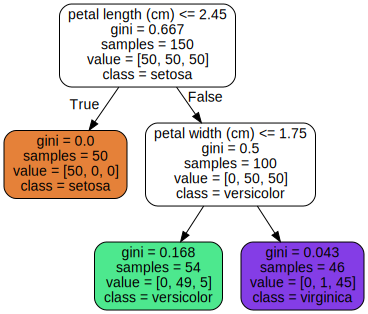

In [325]:
# Visualize the tree
from sklearn.tree import export_graphviz
from graphviz import Source

# Export the tree as graphvis
export_graphviz(
    tree_clf,
    out_file=str(IMAGES_PATH / "iris_tree.dot"),
    feature_names=["petal length (cm)", "petal width (cm)"],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

Source.from_file(IMAGES_PATH / "iris_tree.dot")



# Making Predictions

Predictions are simple to make once you have a trained tree. Let's use the graphvis output above to make predictions and learn how to read the graph.

* The top of the graph shows the root node (depth 0)
* The middle nodes are depth 1, and the last nodes are depth 2
* Nodes without children are leaf nodes
* Nodes with children are split nodes
* The tree is binary (left=True, right=False) because we use the CART algorithm to fit the tree

Let's predict the class for a new iris flower with petal length = 2.1 and petal width = 5.2. The root node asks if the petal length <= 2.45, in this case it is so you end up in the leaf node at depth 1, which indicate the class is setosa

Let's predict the class for another iris flower with petal length = 5.5 and petal width = 1.5. The root node (petal length <= 2.45) leads us to the split node on depth 1. This in turn asks if the petal width <= 1.75, which it is so we end up in the green leaf node indicating the class is versicolor

In [326]:
X_test = [
    [2.1, 5.2],
    [5.5, 1.5]
]

tree_clf.predict(X_test)

array([0, 1])

In [327]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

The nodes of the tree show additional info:

* `samples`: Counts how many training instances it applies to. There are 150 instances at the root node, 50 have petal length <= 2.45. Out of the 100 instances left, 54 have petal width <= 1.75 and 46 have petal width >1.75
* `value`: How many training instances of each class this node applies to. For exmple, the green leaf node applies to 0 Setosa, 49 versicolor and 5 virginica
* `gini`: Measures the _Gini impurity_. The node is "pure" (`gini=0`) if all training instances it applies to belong to the same class. Orange leaf (right node/depth 1) applies to setosa flower only. 

## Computing the Gini Impurity
The _Gini impurity_ $G_i$ for a node $i$ can be calculated as:
$$
G_i = 1 - \sum_{k=1}^{n} p_{i, k}^2
$$

Where $p_{i, k}$ is the ratio of instances belonging to class $k$ among all training instances in the $i$ node

* For the orange node (left node/depth 1):
$$
G_1 = 1 - (\frac{50}{50})^2 - (\frac{0}{50})^2 - (\frac{0}{50})^2 = 0
$$

* For green node (left node/depth 2)
$$
G_3 = 1 - (\frac{0}{54})^2 - (\frac{49}{54})^2 - (\frac{5}{54})^2 = 0.1680384087791
$$

* For magenta node (right node/depth 2)
$$
G_4 = 1 - (\frac{0}{46})^2 - (\frac{1}{46})^2 - (\frac{45}{46})^2 = 0.04253308129
$$

## Estimating Class Probabilities

For a specific instance, traverse the tree and find the leaf node for the instance. The probabilities for each class can be computed using the ratio of training instances in that leaf node and its number of samples.

Examples:
* Instance `[1.2, 5.2]` will end up in (left node/depth 1). The prbabilities are:
   * $p(k=0) = \frac{50}{50} = 1$ (PREDICTED CLASS)
   * $p(k=0) = \frac{0}{50} = 0$
   * $p(k=0) = \frac{0}{50} = 0$


* Instance `[5.5, 1.5]` will end up in (left node/depth 2). The prbabilities are:
   * $p(k=0) = \frac{0}{54} = 0$
   * $p(k=0) = \frac{49}{54} = 0.90740741$ (PREDICTED CLASS)
   * $p(k=0) = \frac{5}{54} = 0.09259259$

In [328]:
X_test

[[2.1, 5.2], [5.5, 1.5]]

In [329]:
tree_clf.predict_proba(X_test)

array([[1.        , 0.        , 0.        ],
       [0.        , 0.90740741, 0.09259259]])

In [330]:
tree_clf.predict(X_test)

array([0, 1])

## Ploting the Decision Boundaries

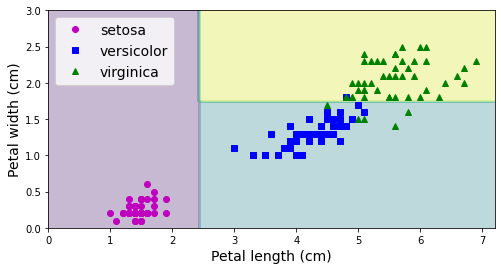

In [331]:
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3)

# Plot the raw data
for idx, (name, style) in enumerate(zip(iris.target_names, ("mo", "bs", "g^"))):
  plt.plot(X_iris[:, 0][y_iris==idx], X_iris[:, 1][y_iris==idx],
           style, label=f"{name}")


plt.xlabel("Petal length (cm)")  
plt.ylabel("Petal width (cm)")
plt.legend()
plt.show()

The tree structure and all of its info (including the ones displayed using graphviz) can be accessed directly

In [332]:
tree = tree_clf.tree_

In [333]:
tree.node_count

5

In [334]:
tree.max_depth

2

In [335]:
tree.max_n_classes

3

In [336]:
tree.n_leaves

3

In [337]:
# Gini impurities
tree.impurity

array([0.66666667, 0.        , 0.5       , 0.16803841, 0.04253308])

In [338]:
# root node index is 0
print(tree.children_left[0]) # index of left child
print(tree.children_right[0]) # index of right child

1
2


In [339]:
# when the left and right children index are equal, you are at a leaf node
tree.children_left[1], tree.children_right[1]

(-1, -1)

In [340]:
# indecies of leaf nodes
is_leaf = (tree.children_left == tree.children_right)
np.arange(tree.node_count)[is_leaf]

array([1, 3, 4])

In [341]:
# split notes use a feature to peform a split. The features are available
tree.feature

# values for leaf nodes should be ignored

array([ 0, -2,  1, -2, -2], dtype=int64)

In [342]:
# threshold used for each feature
tree.threshold

array([ 2.44999999, -2.        ,  1.75      , -2.        , -2.        ])

In [343]:
# values
tree.value

array([[[50., 50., 50.]],

       [[50.,  0.,  0.]],

       [[ 0., 50., 50.]],

       [[ 0., 49.,  5.]],

       [[ 0.,  1., 45.]]])

In [344]:
tree.n_node_samples

array([150,  50, 100,  54,  46], dtype=int64)

In [345]:
# you can compute the depth of each node as follows:

def compute_depth(tree_clf):
    tree = tree_clf.tree_
    depth = np.zeros(tree.node_count)
    stack = [(0, 0)]
    while stack:
        node, node_depth = stack.pop()
        depth[node] = node_depth
        if tree.children_left[node] != tree.children_right[node]:
            stack.append((tree.children_left[node], node_depth + 1))
            stack.append((tree.children_right[node], node_depth + 1))
    return depth

depth = compute_depth(tree_clf)
depth

array([0., 1., 1., 2., 2.])

In [346]:
# get the feature and it threshold of all split nodes at depth 1

print(tree.feature[(depth == 1) & (~is_leaf)])
print(tree.threshold[(depth == 1) & (~is_leaf)])

[1]
[1.75]


# The CART Training Algorithm

`sklearn` uses the ***Classification and Regression Tree (CART)*** algorithm to train (or grow) trees. The logic behind the algorithm is simple, use a single feature $k$ (i.e. petal length) and a threshold $t_k$ (i.e. <= 2.45) to split the training data into two subsets. $k$ and $t_k$ are chosen to produce the purest subsets, weighted by their size. The associated cost function:
$$
J(k, t_k) = \frac{m_{left}}{m}G_{left} + \frac{m_{right}}{m}G_{right}
$$
Where:
$$
\begin{cases}
G_{left/right} & \text{measures the impurity of the left/right subset} \\
m_{left/right} & \text{is the number of instances in the left/right subset}
\end{cases}
$$

Once a split is completed, the subsets are split using the same logic, then the sub-subsets, and so on. The splitting should stop once a maximum depth (`max_depth`) is reached or if there is no split that will reduce impurity. 

The CART algorithm is a _greedy_ algorithm which finds a reasonably good but not necessarily optimum solution

# Regularization Hyperparameters

Decision trees should be regularized because if left unconstrained, they are prone to overfitting. 

`DecisionTreeClassifier` the following hyperparameters:
* `max_depth`: The maximum depth of the tree (`None` = unlimited)
* `max_features`: The number of features to consider when looking for the best split
* `max_leaf_nodes`: Maximum number of leaf nodes
------------
* `min_samples_split`: The minimum number of saples required to split a node
* `min_samples_leaf`: Minimum number of samples required a leaf node must have to be created
* `min_weight_fraction_leaf`: Same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances

***Increasing `min_` or decreasing `max_` hyperparameters will regularize the model***

In [347]:
# helper functions

def plot_dataset(X, y, axes):
  plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
  plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
  plt.axis(axes)
  plt.grid(True)
  plt.xlabel("$x_1$")
  plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
  x1s = np.linspace(axes[0], axes[1], 100)
  x2s = np.linspace(axes[2], axes[3], 100)
  x1, x2 = np.meshgrid(x1s, x2s)
  X = np.c_[x1.ravel(), x2.ravel()]
  y_pred = clf.predict(X).reshape(x1.shape)
  plt.contourf(x1, x2, y_pred, cmap=plt.cm.brg, alpha=0.2)
  plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)


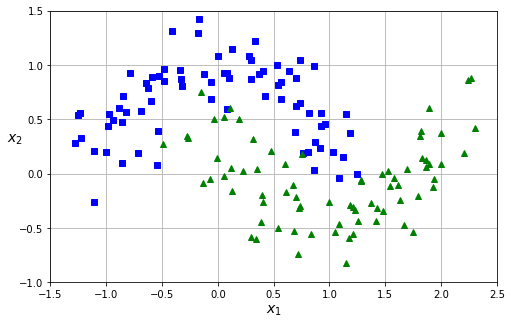

In [348]:
# Make two interleaving half circles

from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

plt.figure(figsize=(8, 5))
plot_dataset(X_moons, y_moons, [-1.5, 2.5, -1, 1.5])
plt.show()

In [349]:
tree_clf1 = DecisionTreeClassifier(random_state=42) # no restrictions
tree_clf1.fit(X_moons, y_moons)

tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42) 
tree_clf2.fit(X_moons, y_moons)


DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

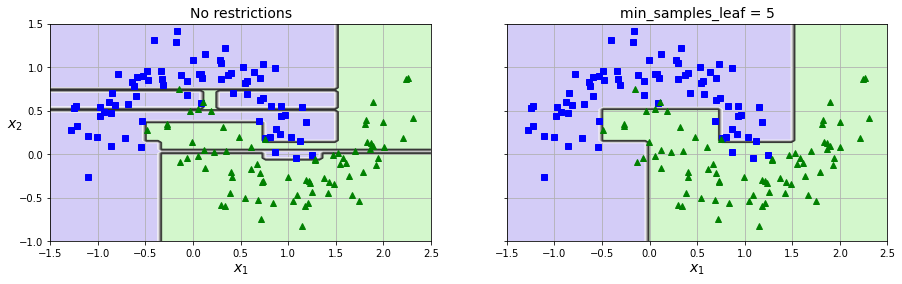

In [350]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(tree_clf1, [-1.5, 2.5, -1, 1.5])
plot_dataset(X_moons, y_moons, [-1.5, 2.5, -1, 1.5])
plt.title("No restrictions")

plt.sca(axes[1])
plot_predictions(tree_clf2, [-1.5, 2.5, -1, 1.5])
plot_dataset(X_moons, y_moons, [-1.5, 2.5, -1, 1.5])
plt.title("min_samples_leaf = {}".format(tree_clf2.min_samples_leaf))
plt.ylabel("")

plt.show()


In [351]:
# generate a moons test set (with a different random seed)
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2, random_state=43)

In [352]:
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [353]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92

Seems the regularized model performed slightly better.

# Regression

Decision Trees can be used for regression. Let's test them on a noisy quadratic dataset

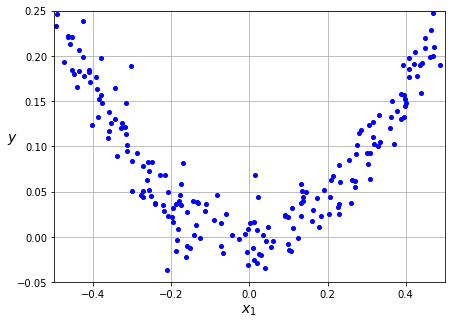

In [354]:
# generate non-linear quadratic regression data

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5
y_quad = X_quad[:, 0] ** 2 + 0.025 * np.random.randn(200) 

plt.figure(figsize=(7, 5))
plt.plot(X_quad, y_quad, "bo", markersize=4)
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.grid()
plt.show()

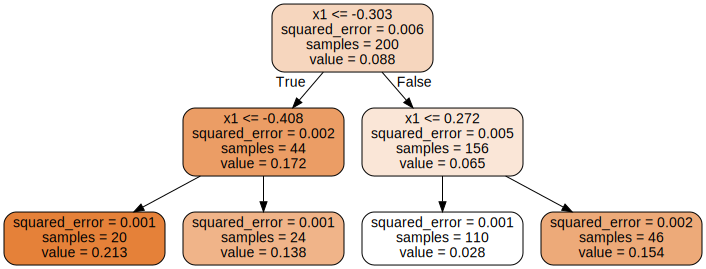

In [355]:
# Train a Decision tree regressor
from sklearn.tree import DecisionTreeRegressor

max_depth = 2
#max_depth = 3
#max_depth = None

tree_reg = DecisionTreeRegressor(max_depth = max_depth, random_state=42)
tree_reg.fit(X_quad, y_quad)

export_graphviz(
    tree_reg,
    out_file=str(IMAGES_PATH / "regression_tree.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True
)

Source.from_file(IMAGES_PATH / "regression_tree.dot")

## Predicting a value

Similar to classification, predicting a value for a new instance is simple once you have a trained regression tree.

Say you want to predict the value for $x_1 = 0.2$:
* Root node: Tests $x_1 \leq -0.303$ (False, move to the right child on depth 1)
* Right split node on depth 1 test $x1 \leq 0.272$ (True, move to the left child on depth 2)
* Leaf node predicts a value of $0.028$ which is the average for all 110 samples in that leaf and the average MSE (for all 110 samples) is 0.001

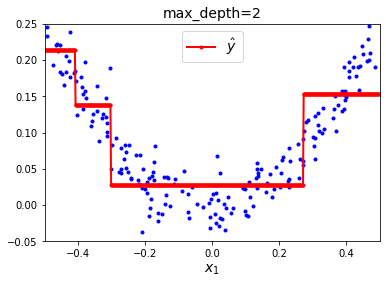

In [356]:
# Plot the regressor

def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
  x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
  y_pred = tree_reg.predict(x1)
  plt.plot(X, y, "b.")
  plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")
  plt.axis(axes)
  plt.xlabel("$x_1$")

plot_regression_predictions(tree_reg, X_quad, y_quad)
plt.title(f"max_depth={tree_reg.tree_.max_depth}")
plt.legend(loc="upper center")
plt.show()

Each segment of the prediction line is the average of all points within its region. In other words, the training algorithms tries to create regions where the training instances are as close as possible to the predicted value.

## The CART Training Algorithm

The CART for regression works in the same way it works for classification; however, instead of spliting the trainin set so the impurity is minimized, it now splits the training set so that the MSE is minimized for the different subsets. The cost function is:

$$
J(k, t_k) = \frac{m_{left}}{m}\text{MSE}_{left} + \frac{m_{right}}{m}\text{MSE}_{right}
$$
Where: $
\begin{cases}
\text{MSE}_{\text{node}} = \frac{\sum_{i \in \text{node}} (\hat{y}_{\text{node}} - y^{(i)})^2}{m_{\text{node}}} \\
\hat{y}_{\text{node}} = \frac{\sum_{i \in \text{node}} y^{(i)}}{m_{\text{node}}} \\
\end{cases}
$

## Regularization Hyperparameters

Similar to classification, decision trees for regression are also prone to over fitting and should be regularized.

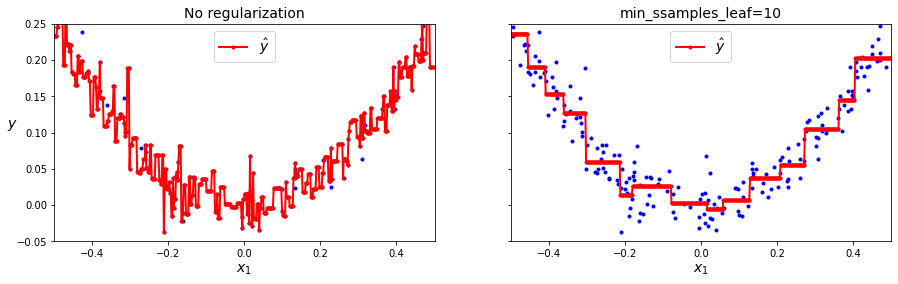

In [357]:
# no regularization
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg1.fit(X_quad, y_quad)
# Some regularization

min_samples_leaf = 10

tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=min_samples_leaf)
tree_reg2.fit(X_quad, y_quad)

fig, axes = plt.subplots(ncols=2, figsize=(15, 4), sharey=True)

plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X_quad, y_quad)
plt.legend(loc="upper center")
plt.title("No regularization")
plt.ylabel("$y$", rotation=0)
plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X_quad, y_quad)
plt.legend(loc="upper center")
plt.title(f"min_ssamples_leaf={tree_reg2.min_samples_leaf}")

plt.show()

The left figure is obviously overfitting the training data; whereas, the right figure shows that setting the minimum number of instances in a leaf to 10 (moderate regularization) produces a more reasonable model.

# Sensitivity to Axis Orientation

Decision trees generate orthogonal decision boundaries (all perpendicular to an axis). This makes them senesitive to data orientation. 

The following shows an example of a dataset and a rotated version of it both fitted with trees of the same hyperparameters. The tree model fitted with the rotated data can sepearte all points successfully; however, the decision boundary is more convoluted and will probably not generalize as well.

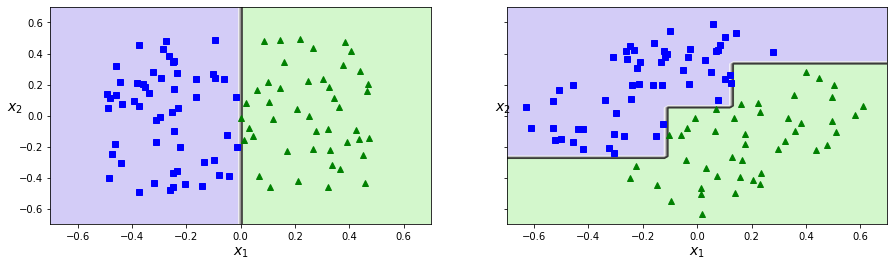

In [358]:
# Generate some linearly separable data
np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

# Generate a rotated version of the same data 
angle = np.pi / 4 # rotation angle = 45 degrees
rotation_matrix = np.array([
    [np.cos(angle), -np.sin(angle)],
    [np.sin(angle), np.cos(angle)]
])

X_rotated_square = X_square.dot(rotation_matrix)

# Fit classification trees
tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)

tree_clf_rotate_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotate_square.fit(X_rotated_square, y_square)

# Plot the decision boundaries
fig, axes = plt.subplots(ncols=2, figsize=(15, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(tree_clf_square, [-0.7, 0.7, -0.7, 0.7])
plot_dataset(X_square, y_square, [-0.7, 0.7, -0.7, 0.7])
plt.grid(False)

plt.sca(axes[1])
plot_predictions(tree_clf_rotate_square, [-0.7, 0.7, -0.7, 0.7])
plot_dataset(X_rotated_square, y_square, [-0.7, 0.7, -0.7, 0.7])
plt.grid(False)

plt.show()

One approach to reduce this limitation is to scale the data then transform it using principal component analysis (PCA). PCA decorrelate the data and transform it to a space where the eigen vector are the axes. 

**NOTE**: this approach might make things easier for trees (but not always)

In [359]:
# Display pipelines
from sklearn import set_config
set_config(display="diagram")

In [360]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca_pipeline = make_pipeline(
    StandardScaler(),
    PCA()
)

X_rotated_square_pca = pca_pipeline.fit_transform(X_rotated_square)

pca_pipeline #to display the pca pipeline


Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

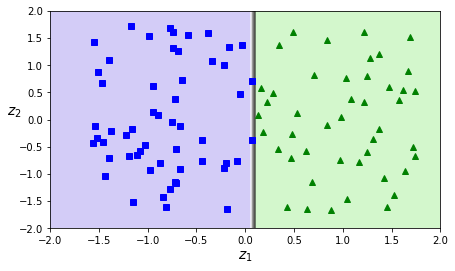

In [361]:
# Fit classification trees
tree_clf_pca = DecisionTreeClassifier(random_state=42)
tree_clf_pca.fit(X_rotated_square_pca, y_square)

# Plot the decision boundary
plt.figure(figsize=(7, 4))
plot_predictions(tree_clf_pca, [-2, 2, -2, 2])
plot_dataset(X_rotated_square_pca, y_square, [-2, 2, -2, 2])
plt.grid(False)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)


plt.show()

The decision boundary is much simpler after scaling and PCA transformation

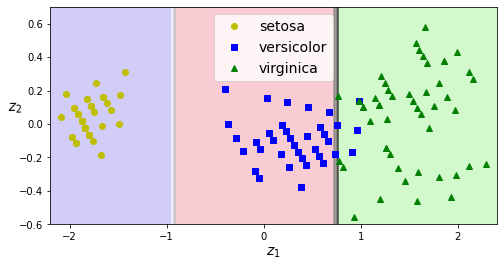

In [362]:
# Scale/PCA the iris dataset

X_iris_pca = pca_pipeline.fit_transform(X_iris)
tree_clf_iris_pca = DecisionTreeClassifier(random_state=42, max_depth=2)
tree_clf_iris_pca.fit(X_iris_pca, y_iris)

# Plot the decision boundary
plt.figure(figsize=(8, 4))
axes = [-2.2, 2.4, -0.6, 0.7]
plot_predictions(tree_clf_iris_pca, axes)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_pca[:, 0][y_iris == idx],
             X_iris_pca[:, 1][y_iris == idx],
             style, label=f"{name}")
plt.xlabel("$z_1$")  
plt.ylabel("$z_2$", rotation=2)
plt.legend(loc="upper center")
plt.show()

